# Marginal Probabilities with Elimination algorithms

Dmytro Fedoriaka, February-March 2021

This notebook is experimental part of a paper on computing marginal probabilities for probabilistic Graphical Models using Elimination Algorithms. The paper is currently work in progress.

## Experiments

We run a series of experiments to compare accuracy and running time of proposed algorithms with some existing algorithms for computing marginal probabilities.

### Algorithms

We run the following algorithms:

* MBE-TR - Mini-Bucket elimination + Trivial Reduction (with varying ibound);
* MBR-TR - Mini-Bucket renormaliztion + Trivial Reduction (with varying ibound);
* MBE-BT - Mini-Bucket elimination + Binary Tree Elimination (with varying ibound);
* MBR-BT - Mini-Bucket renormaliztion + Binary Tree Elimination (with varying ibound);
* BP - Belief propagation;
* TRWBP - Tree-Reweighted Belif Propagation.

Algorithms MBE-TR, MBE-TR, MBE-BT, MBR-BT are implemented in the [InferLO](https://github.com/InferLO/inferlo) library as part of current project.

Algorithms BP and TRWBP are used from [LibDAI](https://staff.fnwi.uva.nl/j.m.mooij/libDAI/) library, using InferLO's adapter. These are benchmarks so it's reasonable to use independednt implementation.

Also as part of this project we also implemented Trivial Reduction and Binary Tree Elimination for Bucket Elimination, but they don't appear in the experiments. Thats because:

* They guaranteed to give exact result;
* Their running time omn big datasets is so big it's impractical;
* On synthetic Ising Grid datasets BE + Trivial Reduction gives misleadingly fast results because of special structure of the model, which womn't happen in the general case. We used this to get exact marginal probabilities for Experiment 1.


### Accuracy metric

We used the mean Kullback-Leibler divergence as accuracy metric:

$$ \text{MKLD}(p) = \frac{1}{n} \sum_{i=1}^{n} \sum_{j=1}^{d_i} p_{i,j} \ln \left(\frac{p_{i,j}}{\max(\hat{p}_{i,j},10^{-10})}\right),$$

where $p$ is marginal probabilities given by the model and $\hat{p}$ are knwon true marginal probabilities. 

Note that some datasets have true probabilities for some values of some variables equal to 0, which would result in the division by 0, so we had adjust such proabilities to be equal to very small positive value ($10^{-10}$).


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import time
import networkx as nx
from scipy.special import kl_div
import sys

sys.path.append('../..')
import inferlo
from inferlo import InferenceResult
from inferlo.datasets import DatasetLoader, Dataset
from inferlo.interop import LibDaiInterop
import inferlo.generic.inference as inf
from inferlo import testing

loader = DatasetLoader(data_dir='~/inferlo_datasets')
libdai = LibDaiInterop()
exp_runner = testing.ExperimentRunner(data_dir='~/inferlo_experiments')
assert libdai.is_libdai_ready()


def mean_kl_div(p, q):
    q = np.maximum(q, 1e-10)   
    return np.mean(np.sum(kl_div(p, q), axis=1))

### Experiment 1 : Ising Grid.

We generate grid graph of size $13 \times h$, where $h$ is in range $[1, 30]$. On this graph we build a syntetic Ising model ($x_i = \{ -1, 1 \} $):

$$f(\mathbf{x}) = \exp \left(\sum_{i \in \mathcal{V}} \phi_i x_i + \sum_{(i,j) \in \mathcal{E}} \phi_{ij} x_i x_j \right).$$

We draw $\phi_i$ and $\phi_{i,j}$ uniformly from intervals [-1, 1].

We get exact marginal probabilities by running Bucket Elimination + Trivial Reduction.

Then for every model we run algorithms BP, MBE-BT, MBR-BT, MBE-TR, MBR-TR. ibound in these experiment is always 9.

The charts below for each model show running time and accuracy (mean KL divergence).

In [3]:
def ising_grid_dataset(width, height, seed=0):
    dataset_name = 'ising_grid_%dx%d_seed=%d' % (width, height, seed)
    if loader.custom_dataset_exists(dataset_name):
        return loader.load_custom_dataset(dataset_name)
    graph = nx.grid_graph(dim=(width, height))
    model_pwf = testing.ising_model_on_graph(
        graph, field_range=1.0, interaction_range=1.0, seed=0)
    model = inferlo.GenericGraphModel.from_model(model_pwf)
    result = inf.get_marginals(
        model, 
        lambda m: inf.bucket_elimination(m, elimination_order_method='not_random'),
        skip_last=True)
    dataset = Dataset(model=model,
                      true_log_pf=result.log_pf,
                      true_marginals=result.marg_prob,
                      name=dataset_name)
    loader.save_custom_dataset(dataset)
    return dataset


def compare_marginals_ising_grid(w=0, h=0, ibound=0, algo=''):
    assert w>0 and h>0
    dataset = ising_grid_dataset(w, h)
    
    if algo == 'BP':
        result = libdai.infer(dataset.model, 'BP')
    elif algo == 'MBE':
        result = inf.mini_bucket_elimination(dataset.model, ibound=ibound)
        result = inferlo.InferenceResult(log_pf=result, marg_prob=np.nan)
    elif algo == 'MBR':
        result = inf.bucket_renormalization(dataset.model, ibound=ibound, max_iter=0)
        result = inferlo.InferenceResult(log_pf=result, marg_prob=np.nan) 
    elif algo == 'MBE-BT':
        result = inf.mini_bucket_elimination_bt(dataset.model, ibound=ibound)
    elif algo == 'MBE-TR':
        result = inf.get_marginals(
            dataset.model, 
            lambda m: inf.mini_bucket_elimination(m, ibound=ibound))
    elif algo == 'MBE-BT':
        result = inf.mini_bucket_elimination_bt(dataset.model, ibound=ibound)
    elif algo == 'MBR-TR':
        result = inf.get_marginals(
            dataset.model, 
            lambda m: inf.bucket_renormalization(m, ibound=ibound, max_iter=0))       
    elif algo == 'MBR-BT':
        result = inf.mini_bucket_renormalization_bt(dataset.model, ibound=ibound)  
    else:
        raise ValueError("Unknown algorithm: %s" % algo)
        
    return {
      "log_pf_error": np.abs(result.log_pf - dataset.true_log_pf),
      "mean_abs_mp_diff": np.mean(np.abs(result.marg_prob - dataset.true_marginals)),
      "max_abs_mp_diff": np.max(np.abs(result.marg_prob - dataset.true_marginals)),
      "mean_kl_div": mean_kl_div(result.marg_prob, dataset.true_marginals)     
    }

w=13
for h in range(1, 31):   
    ising_grid_dataset(w,h)
    #print('Grid is %dx%d' % (w,h))
    algos = ['BP', 'MBE', 'MBR', 'MBE-BT', 'MBR-BT']
    if h <= 10:
        algos += ['MBE-TR', 'MBR-TR']
    for algo in algos:
        result = exp_runner.run_experiment(
            compare_marginals_ising_grid,
            {'w':w,'h':h,'ibound':9,'algo':algo})

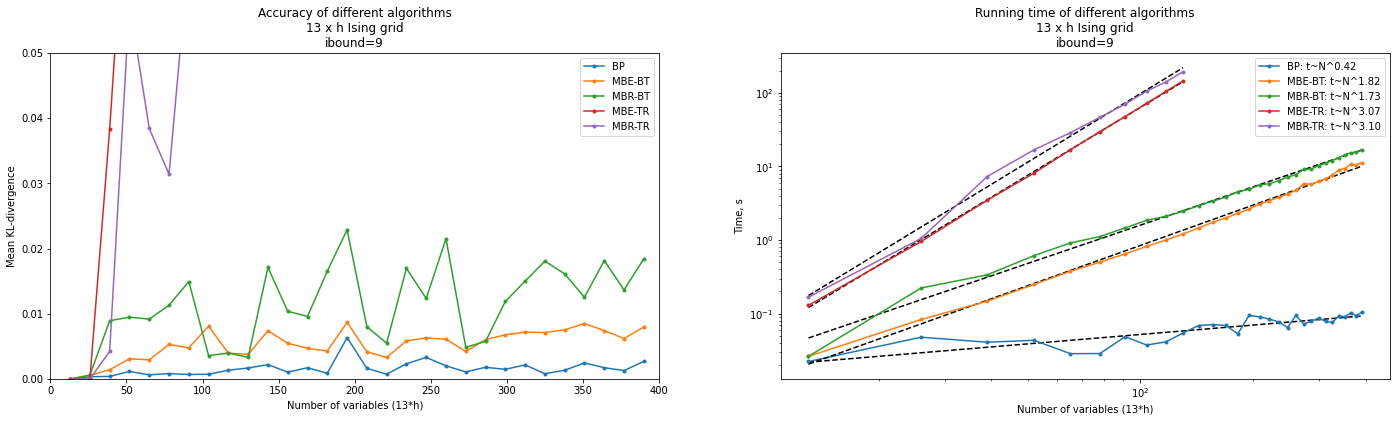

In [4]:
plt.figure(figsize=(24, 6))
ax_mkld=plt.subplot(1, 2, 1)
ax_time=plt.subplot(1, 2, 2)

for algo in ['BP', 'MBE-BT', 'MBR-BT', 'MBE-TR', 'MBR-TR']:
    results = exp_runner.get_results('compare_marginals_ising_grid', 
                                     filter_params={'w':w,'ibound':9,'algo':algo})
    h_to_time = {r['params']['h']: r['result']['elapsed_time'] for r in results}
    h_to_mkld = {r['params']['h']: r['result']['mean_kl_div'] for r in results}
    h_range = np.sort(np.array(list(h_to_time.keys())))
    num_vars_range = w * np.array(h_range)
    time_chart = [h_to_time[h] for h in h_range]
    mkld_chart = [h_to_mkld[h] for h in h_range]
    ax_mkld.plot(num_vars_range, mkld_chart, label=algo, marker='.')
    
    
    k, x0 = np.polyfit(np.log(num_vars_range), np.log(time_chart), deg=1)
    ax_time.plot(num_vars_range, np.exp(x0)*(num_vars_range**k), '--', color='black')
    ax_time.plot(num_vars_range, time_chart, label='%s: t~N^%.02f' % (algo, k), marker='.')

    

ax_mkld.set_xlim([0, 400])
ax_mkld.set_ylim([0, 0.05])
ax_mkld.set_xlabel('Number of variables (13*h)')
ax_mkld.set_ylabel('Mean KL-divergence')
ax_mkld.set_title('\n'.join(['Accuracy of different algorithms',
                             '%d x h Ising grid' % w,
                             'ibound=9']))

ax_time.set_xlabel('Number of variables (13*h)')
ax_time.set_ylabel('Time, s')
ax_time.set_xscale('log')
ax_time.set_yscale('log')
ax_time.set_title('\n'.join(['Running time of different algorithms',
                             '%d x h Ising grid' % w,
                             'ibound=9']))

    
ax_mkld.legend()
ax_time.legend()
plt.show()


We can see that Binary Tree Elimination is much better than Trivial Reduction both in terms of accuracy and running time.

We also fitted running time as function of number of variables in log-scale, and it appers that Trivial Reduction takes $O(n^{3.1})$ time, while Bucket Elimination takes $O(n^{1.7})$ time.

Belief Propagation outperforms both MBE and MBR in accuracy and time, but these are very simple models, and ibound was deliberately chosen so these models don't give exact answers. 

Main goal of this experiment was to prove that Binary Tree Elimination is much better than Trivial Reduction both in terms of accuracy and running time.

We also calculated "relative" running time for MBE-BT, MBR-BT, MBE-TR, MBR-TR. Fo that, we divided running time by the running time of the base algorithm (i.e. the algorithm which does full elimination once and just computes partition function).

Results are below.

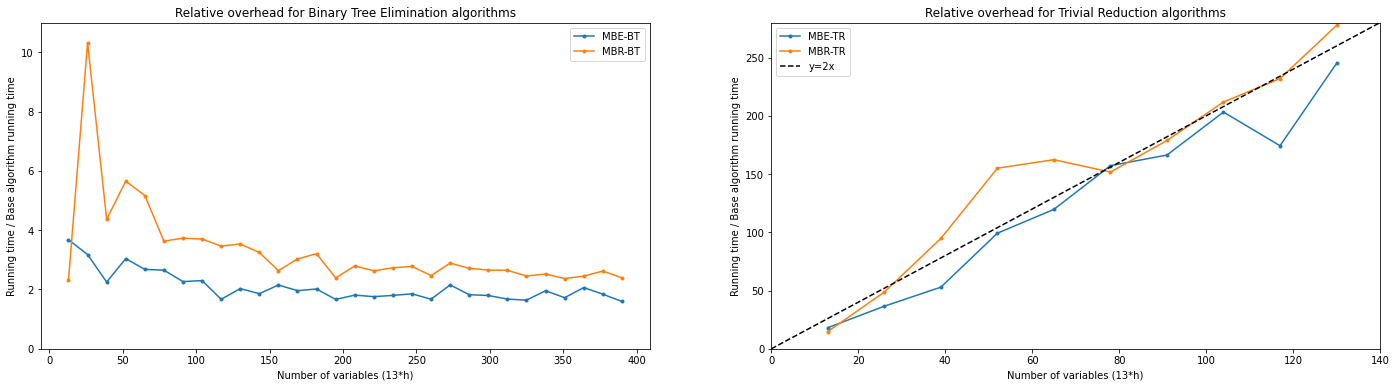

In [5]:
plt.figure(figsize=(24, 6))
ax1=plt.subplot(1, 2, 1)
ax2=plt.subplot(1, 2, 2)

for algo in ['MBE-BT', 'MBR-BT', 'MBE-TR', 'MBR-TR']:
    base_algo = algo[:3]
    base_results = exp_runner.get_results('compare_marginals_ising_grid', 
                                     filter_params={'w':w,'ibound':9,'algo':base_algo})
    results = exp_runner.get_results('compare_marginals_ising_grid', 
                                     filter_params={'w':w,'ibound':9,'algo':algo})
    h_to_base_time = {r['params']['h']: r['result']['elapsed_time'] for r in base_results}
    h_to_time = {r['params']['h']: r['result']['elapsed_time'] for r in results}
    
    h_range = np.sort(np.array(list(h_to_time.keys())))
    num_vars_range = w * np.array(h_range)
    time_chart = [h_to_time[h]/h_to_base_time[h] for h in h_range]
    ax = ax1 if 'BT' in algo else ax2
    ax.plot(num_vars_range, time_chart, label=algo, marker='.')

ax1.legend()
ax1.set_ylim([0, 11])
ax1.set_xlabel('Number of variables (13*h)')
ax1.set_ylabel('Running time / Base algorithm running time')
ax1.set_title('Relative overhead for Binary Tree Elimination algorithms')

ax2.plot([0, 140], [0, 280], '--', color='black', label='y=2x')
ax2.set_xlim([0, 140])
ax2.set_ylim([0, 280])
ax2.legend()
ax2.set_xlabel('Number of variables (13*h)')
ax2.set_ylabel('Running time / Base algorithm running time')
ax2.set_title('Relative overhead for Trivial Reduction algorithms')



plt.show()


For Trivial Reduction algorithms, as expected, relative running time is close to line y=2x, that is for model with N variables we call base algorithm $2 \times N$ times (2 because variables are binary).

For Binary Tree Elimination we got results even better then expected (if we ignore results for small models). We expected it to be like $y=\log_2(x)$, and $log_2(13 \times 30) \approx 9$, but it is almost constant (2 for MBE-BT and 3 dor MBR-BT). 

This can be explained as follows: as model becomes smaller, eliminations are cheaper, and most eliminations are done on small models. For example, $n (log_2(n)-1)$ eliminations are done on model having less than $n/2$ variables.

### Experiment 2: UAI datasets with varying ibound.

We took 10 linkage datasets from UAI competitions. For each of them ran:

* MBE-BT with ibound in range [4, 15].
* MBR-BT with ibound in range [4, 11].
* BP
* TRWBP

Sometimes BP failed. Sometimes MBR-BT failed (*investigate: might be a bug in implemntation)*. For these cases data is missing on the chart.

Results are shown on charts below. In 6 of 8 cases MBE-BT outperforms both PB and TRWBP in accuracy.

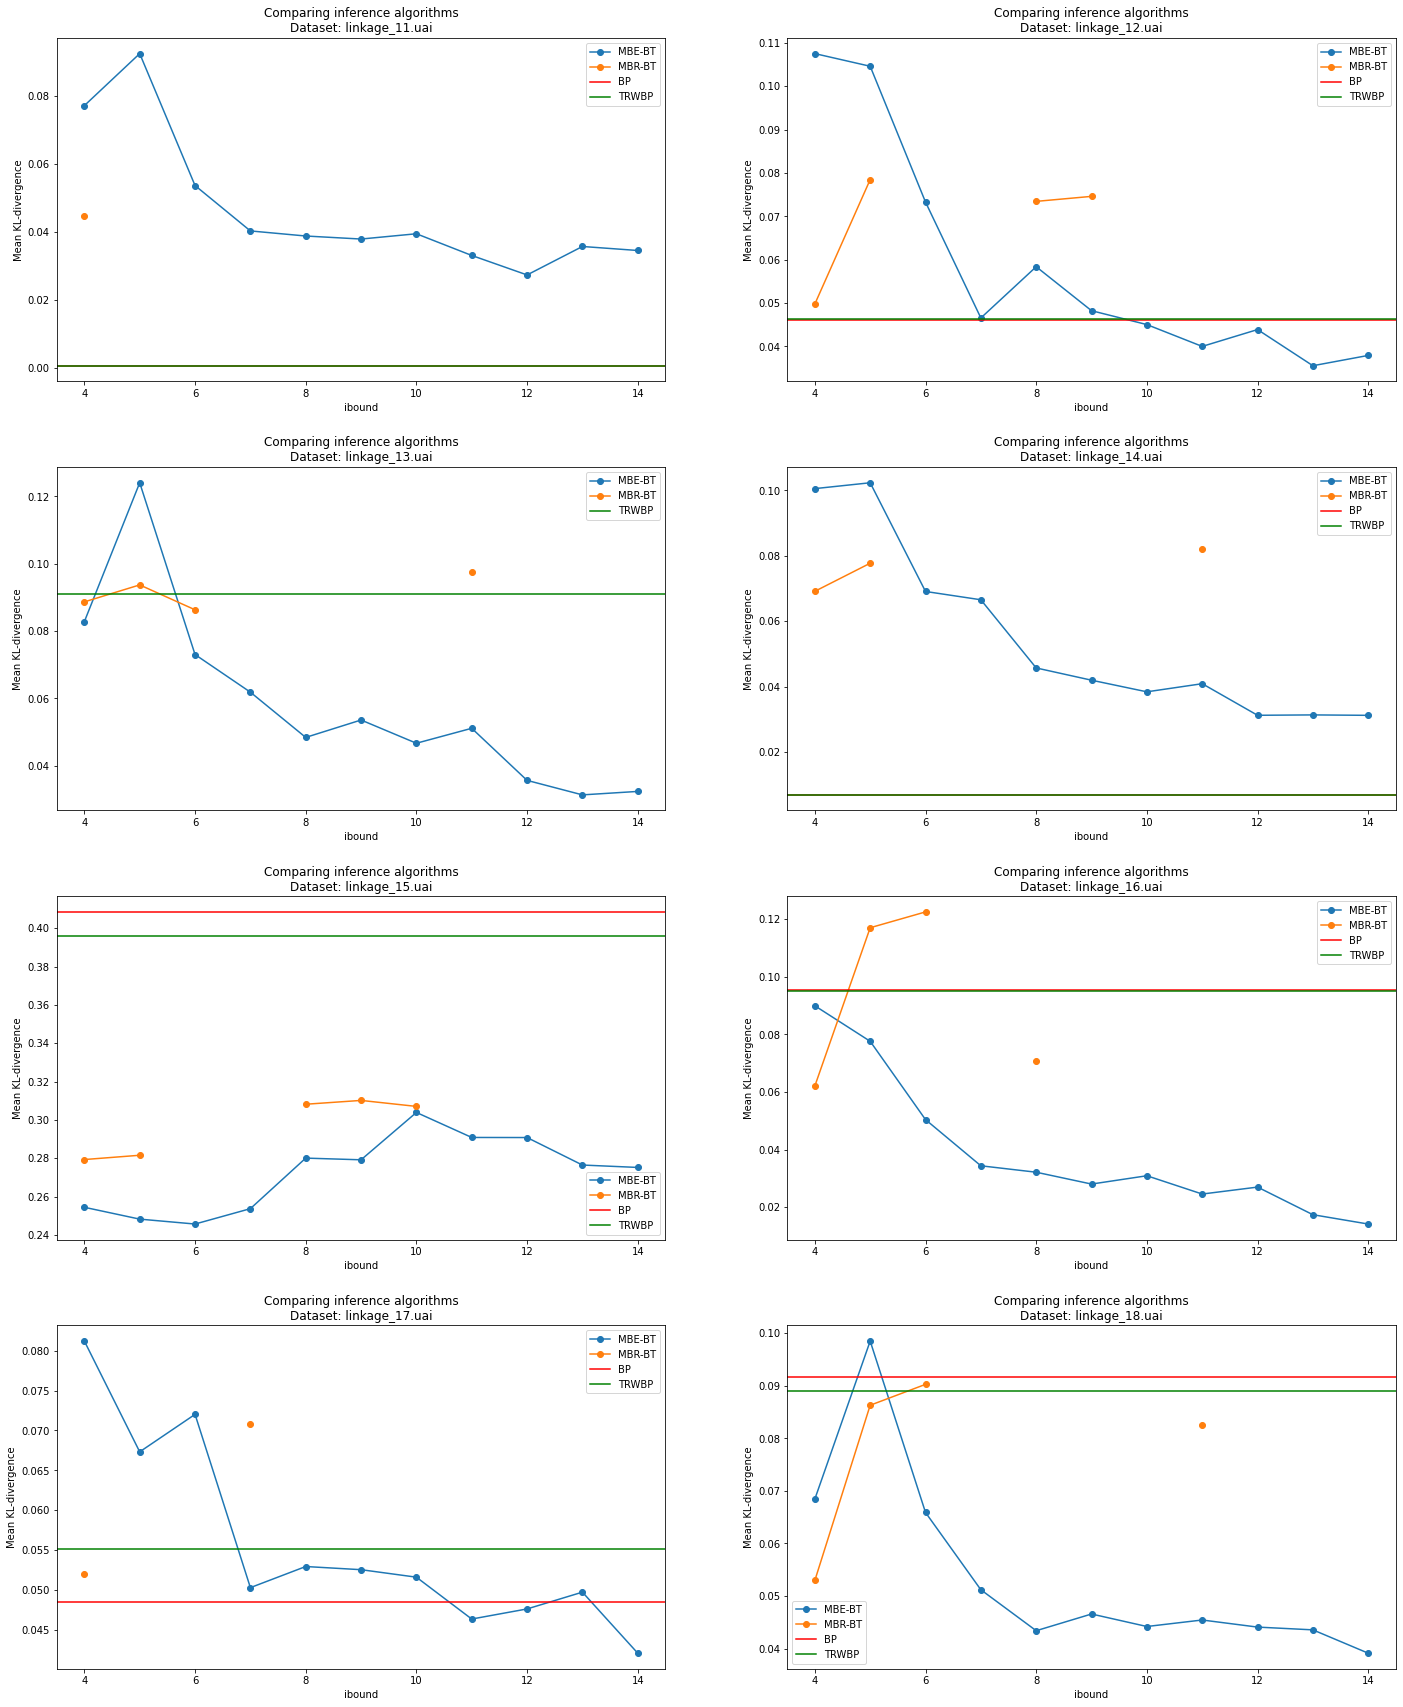

In [6]:
def compare_marginals_uai(dataset_name='', ibound=0, algo=''):
    dataset = loader.load_uai_dataset(dataset_name)
    
    if algo == 'BP':
        try:
            result = libdai.infer(dataset.model, 'BP')
        except:
            return None
    elif algo == 'TRWBP':
        result = libdai.infer(dataset.model, 'TRWBP')
    elif algo == 'MBE-BT':
        result = inf.mini_bucket_elimination_bt(dataset.model, ibound=ibound)
    elif algo == 'MBR-BT':
        result = inf.mini_bucket_renormalization_bt(dataset.model, ibound=ibound)  
    else:
        raise ValueError("Unknown algorithm: %s" % algo)
        
    return {
      "log_pf_error": np.abs(result.log_pf - dataset.true_log_pf),
      "mean_abs_mp_diff": np.mean(np.abs(result.marg_prob - dataset.true_marginals)),
      "max_abs_mp_diff": np.max(np.abs(result.marg_prob - dataset.true_marginals)),
      "mean_kl_div": mean_kl_div(result.marg_prob, dataset.true_marginals)     
    }
    

def run_dataset(dataset_name, ax):   
    # Mini-Bucket Elimination + Binary Tree order.
    ibound_range = list(range(4, 15))
    mbe_mkld = []
    for ibound in ibound_range:
        result = exp_runner.run_experiment(compare_marginals_uai, {
            'dataset_name': dataset_name,
            'algo': 'MBE-BT',
            'ibound': ibound
        })
        mbe_mkld.append(result['mean_kl_div'])
    ax.plot(ibound_range, mbe_mkld, label='MBE-BT', marker='o')
    
    # Mini-Bucket Renormalization + Binary Tree order.
    ibound_range = list(range(4, 12))
    mbr_mkld = []
    for ibound in ibound_range: 
        result = exp_runner.run_experiment(compare_marginals_uai, {
            'dataset_name': dataset_name,
            'algo': 'MBR-BT',
            'ibound': ibound
        })
        mbr_mkld.append(result['mean_kl_div'])
    ax.plot(ibound_range, mbr_mkld, label='MBR-BT', marker='o')
    
    
    # Belief Propagation.
    result = exp_runner.run_experiment(compare_marginals_uai, {
            'dataset_name': dataset_name,
            'algo': 'BP'
    }) 
    if 'mean_kl_div' in result and np.isfinite(result['mean_kl_div']):
        ax.axhline(y=result['mean_kl_div'], label='BP', color='red')
    
    # Tree-Reweighted Belief Propagation.
    result = exp_runner.run_experiment(compare_marginals_uai, {
            'dataset_name': dataset_name,
            'algo': 'TRWBP'
    })
    ax.axhline(y=result['mean_kl_div'], label='TRWBP', color='green')
        
    ax.legend()
    ax.set_xlabel('ibound')
    ax.set_ylabel('Mean KL-divergence')
    ax.set_title('Comparing inference algorithms\nDataset: ' + dataset_name)
    

plt.figure(figsize=(24, 30))
datasets = ['linkage_%d.uai' % i for i in range(11,19)]
for i, dataset_name in enumerate(datasets):
    ax=plt.subplot(4, 2, i+1)
    run_dataset(dataset_name, ax)
plt.subplots_adjust(hspace=0.25)
plt.show()